In [2]:
import pandas as pd
import numpy as np

import torch

from zlib import crc32
import warnings


warnings.filterwarnings("ignore") 
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
import numpy as np
import warnings
warnings.filterwarnings("ignore") 
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
import stellargraph as sg 

from gensim.models import Word2Vec

2023-08-19 21:52:45.948910: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-19 21:52:46.024123: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 21:52:46.490495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-19 21:52:46.971506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def convert_to_index(steamid, graph_map):
    if steamid in graph_map:
        return graph_map[steamid]
    else:
        index = len(graph_map)
        graph_map[steamid] = index
        return index

In [4]:
def define_toxic(toxicities, map):
    toxic_people_map = {}
    for key in toxicities.keys():
        data = toxicities[key]
        count = 0
        for element in data:
            if (element >= 0.8):
                count += 1
        if count > 1:
            toxic_people_map[key] = 1
        else:
            toxic_people_map[key] = 0
    toxic = list(np.zeros(len(map)))
    for key in toxic_people_map:
        if key in map:
            toxic[map[key]] = toxic_people_map[key]
    return toxic

In [5]:
def bytes_to_float(b):
    return float(crc32(b) & 0xffffffff) / 2**32
def str_to_float(s, encoding="utf-8"):
    return bytes_to_float(s.encode(encoding))

In [6]:
vector_size = 32

In [7]:
import networkx as nx
from pymongo import MongoClient
count = 2000
client = MongoClient(
f'mongodb://localhost:27017')
mydb = client.get_database("toxic_games")

collection = mydb.get_collection("games")

player_graph = nx.Graph()

steamid_to_index_graph = {}
steamid_to_index_messages = {}
index_to_toxicities = {}

def add_toxicity(index, toxicity):
    if index in index_to_toxicities:
        index_to_toxicities[index].append(toxicity)
    else:
        index_to_toxicities[index] = [toxicity]

# Create a graph

for idx, item in enumerate(collection.find({"lang": "Language.ENGLISH"}).limit(count).allow_disk_use(True)):
    if idx % 1000 == 0:
        print(idx)
    logdata = item["log"]
    players = list(logdata["players"].keys())
    for message in logdata["chat"]:
        if message["steamid"] == "Console":
            continue
        sender = convert_to_index(
            message["steamid"], steamid_to_index_messages)
        add_toxicity(message["steamid"],
                        message["detoxify-original"]["toxicity"])
    
    blue_players = []
    red_players = []
    for key, value in logdata["players"].items():
        if value["team"] == "Red":
            red_players.append(key)
        else:
            blue_players.append(key)

    for player_a in blue_players:
        for player_b in blue_players:
            if player_a != player_b:
                id_a = convert_to_index(player_a, steamid_to_index_graph)
                id_b = convert_to_index(player_b, steamid_to_index_graph)
                if not player_graph.has_edge(id_a, id_b):
                    player_graph.add_edge(id_a, id_b, weight=0.5)
                else:
                    player_graph[id_a][id_b]["weight"] += 0.5

    for player_a in red_players:
        for player_b in red_players:
            if player_a != player_b:
                id_a = convert_to_index(player_a, steamid_to_index_graph)
                id_b = convert_to_index(player_b, steamid_to_index_graph)
                if not player_graph.has_edge(id_a, id_b):
                    player_graph.add_edge(id_a, id_b, weight=0.5)
                else:
                    player_graph[id_a][id_b]["weight"] += 0.5

0


In [8]:
toxicities = define_toxic(index_to_toxicities, steamid_to_index_graph)

In [9]:
G = StellarGraph.from_networkx(player_graph)
print(G.info())
print(len(toxicities))

StellarGraph: Undirected multigraph
 Nodes: 4597, Edges: 25468

 Node types:
  default: [4597]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [25468]
        Weights: range=[1, 8], mean=1.10735, std=0.420006
        Features: none
4597


In [10]:
walk_length = 20

In [11]:
rw = BiasedRandomWalk(G)

In [12]:
weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.7,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=1,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

Number of random walks: 45970


In [13]:
weighted_model = Word2Vec(
    weighted_walks, vector_size=vector_size, window=5, min_count=0, sg=0, workers=4, epochs=2
)

In [14]:
weighted_node_embeddings = weighted_model.wv.vectors

In [15]:
def get_node_embedding(index, own_steamid_to_index : dict):
    steamid = ""
    for key in own_steamid_to_index:
        if own_steamid_to_index[key] == index:
            steamid = key
            break
    if steamid in steamid_to_index_graph:
        return weighted_node_embeddings[steamid_to_index_graph[steamid]]
    else:
        #print("Nothing")
        return np.ones(vector_size)

In [16]:
label_to_number = {
    "NEUTRAL": 0,
    "SLIGHTLY_TOXIC": 1,
    "TOXIC": 2,
    "EXTREMELY_TOXIC": 3
}


def take_average(annotations):
    sum = 0
    count = 0
    for annotation in annotations:
        if annotation != "N_A":
            sum += label_to_number[annotation]
            count += 1
    if count == 0:
        return -1
    label = int(sum/count)
    if label > 2:
        label = 2
    return label

In [17]:
from pymongo import MongoClient
from torch_geometric.data import Data

client = MongoClient(
f'mongodb://localhost:27017')
mydb = client.get_database("toxic_games")

collection = mydb.get_collection("games")

source = []
target = []
steamid2_to_index_graph = {}
features = []
all_features = []
graphs_train = []
graphs_validation = []
graph_labels = []
nodes = []

def get_team(players, player):
    if player not in players:
        return 0
    if players[player]["team"] == "Blue":
        return 1
    else: 
        return 2

for idx, item in enumerate(collection.find({"lang" : "Language.ENGLISH", "problem": {"$exists": False}}).limit(count).allow_disk_use(True)):
    if idx % 100 == 0:
        print(idx)
    logdata = item["log"]["events"]
    players = item["log"]["players"]
    
    for index, event in enumerate(logdata):
        nodes.append([1 if event["kill"] else 0,1 if event["chargeUsed"] else 0,1 if event["medicDrop"] else 0,1 if event["message"] else 0,1 if event["capture"] else 0])
        for index2, event2 in enumerate(logdata):
            if index == index2 or (event["second"] - event2["second"] > 10 or event["second"] - event2["second"] < 0):
                continue
            if event["attacker"] == event2["attacker"]:
                source.append(index)
                target.append(index2)
                player = convert_to_index(event["attacker"], steamid2_to_index_graph)
                feature = [1, get_team(players, event["attacker"])]
                feature.extend(get_node_embedding(player,steamid2_to_index_graph))
                features.append(feature)
            elif event["victim"] and event["victim"] == event2["victim"]:
                source.append(index)
                target.append(index2)
                feature = [0, get_team(players, event["victim"])]
                player = convert_to_index(event["victim"], steamid2_to_index_graph)
                feature.extend(get_node_embedding(player,steamid2_to_index_graph))
                features.append(feature)
    

    players = list(set(target + source))
    if (len(players) == 0):
        source = []
        target = []
        nodes = []
        features = []
        steamid2_to_index_graph = {}
        continue
    
    all_features.append(features)
    toxic = 0
    score = 0
    toxic = take_average(item["annotation"])
    if toxic == -1:
        source = []
        target = []
        nodes = []
        features = []
        steamid2_to_index_graph = {}
        continue
    graph_labels.append(toxic)
    x = torch.tensor(nodes, dtype=torch.float32)
    if item["type"] == "train":
        graphs_train.append(Data(x=x, edge_attr=torch.tensor(features, dtype=torch.float32), edge_index=torch.tensor([source, target], dtype=torch.long),y=torch.Tensor([toxic]).to(torch.long)))
    else:
        graphs_validation.append(Data(x=x, edge_attr=torch.tensor(features, dtype=torch.float32), edge_index=torch.tensor([source, target], dtype=torch.long),y=torch.Tensor([toxic]).to(torch.long)))
    source = []
    nodes=[]
    target = []
    features = []
    steamid2_to_index_graph = {}

0
100
200
300
400
500
600


In [18]:
county = 0
for graph in graphs_validation:
    for edge_value in graph.edge_attr:
        if torch.equal(edge_value[2:],torch.ones(128)):
            county += 1
print(county)

0


In [19]:
pd.DataFrame(graph_labels).value_counts().to_frame()

,count
0,
0,505
1,111
2,56


In [20]:
len(graphs_validation)

511

In [21]:
len(graphs_train)

161

In [22]:
torch.manual_seed(12345)
#dataset = graphs
#split = int(len(dataset)*0.7)
split = int(len(graphs_validation)*0.7)
trainy = graphs_train.copy()
trainy.extend(graphs_validation[:split])
train_dataset = trainy#dataset[:split]

remaining_dataset = graphs_validation[split:]#dataset[split:]
remaining_split = int(len(remaining_dataset)*0.5)

validation_dataset = remaining_dataset[:remaining_split]
test_dataset = remaining_dataset[remaining_split:]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(validation_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 518
Number of validation graphs: 77
Number of test graphs: 77


In [23]:
val_y = list(map(lambda x: x.y.item(), validation_dataset))
pd.DataFrame(val_y).value_counts().to_frame()

,count
0,
0,62
1,11
2,4


In [24]:
from torch_geometric.loader import DataLoader
from torch_geometric.loader.imbalanced_sampler import ImbalancedSampler

train_loader = DataLoader(train_dataset, sampler=ImbalancedSampler(train_dataset), batch_size=16)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 16
DataBatch(x=[4938, 5], edge_index=[2, 1429], edge_attr=[1429, 34], y=[16], batch=[4938], ptr=[17])

Step 2:
Number of graphs in the current batch: 16
DataBatch(x=[4384, 5], edge_index=[2, 1182], edge_attr=[1182, 34], y=[16], batch=[4384], ptr=[17])

Step 3:
Number of graphs in the current batch: 16
DataBatch(x=[4885, 5], edge_index=[2, 1586], edge_attr=[1586, 34], y=[16], batch=[4885], ptr=[17])

Step 4:
Number of graphs in the current batch: 16
DataBatch(x=[5229, 5], edge_index=[2, 1573], edge_attr=[1573, 34], y=[16], batch=[5229], ptr=[17])

Step 5:
Number of graphs in the current batch: 16
DataBatch(x=[4634, 5], edge_index=[2, 1392], edge_attr=[1392, 34], y=[16], batch=[4634], ptr=[17])

Step 6:
Number of graphs in the current batch: 16
DataBatch(x=[6003, 5], edge_index=[2, 1840], edge_attr=[1840, 34], y=[16], batch=[6003], ptr=[17])

Step 7:
Number of graphs in the current batch: 16
DataBatch(x=[5786, 5], edge_index=[2, 1760], edge_

In [25]:
from torch_geometric.utils import degree
max_degree = -1
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

# Compute the in-degree histogram tensor
deg = torch.zeros(max_degree + 1, dtype=torch.long)
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

In [26]:

from torch_geometric.nn import BatchNorm, PNAConv, global_add_pool
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential, Dropout
from torch.optim.lr_scheduler import ReduceLROnPlateau
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        aggregators = ['mean', 'min', 'max', 'std']
        scalers = ['identity', 'amplification', 'attenuation']

        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        for _ in range(2):
            conv = PNAConv(in_channels=5, out_channels=5,
                           aggregators=aggregators, scalers=scalers, deg=deg,
                           edge_dim=vector_size + 2, towers=5, pre_layers=1, post_layers=1,
                           divide_input=False)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(5))

        self.mlp = Sequential(Linear(5, 5), ReLU(), Linear(5, 10), ReLU(),
                              Linear(10, 3))

    def forward(self, x, edge_index, edge_attr, batch):
        x = x#self.node_emb(x.squeeze())
        #edge_attr = self.edge_emb(edge_attr)

        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = F.relu(batch_norm(conv(x, edge_index, edge_attr)))

        x = global_add_pool(x, batch)
        return self.mlp(x)

Epoch: 01, Loss: 3.0010, Val: 2.5232, Test: 2.4482 ROC: 0.4651
Epoch: 02, Loss: 2.3206, Val: 1.7952, Test: 1.7893 ROC: 0.4985
Epoch: 03, Loss: 1.7732, Val: 1.4432, Test: 1.5102 ROC: 0.5153
Epoch: 04, Loss: 1.5824, Val: 1.2238, Test: 1.2457 ROC: 0.5196
Epoch: 05, Loss: 1.4240, Val: 1.1732, Test: 1.1628 ROC: 0.5241
Epoch: 06, Loss: 1.3003, Val: 1.2719, Test: 1.2604 ROC: 0.5229
Epoch: 07, Loss: 1.2015, Val: 1.2939, Test: 1.2578 ROC: 0.5275
Epoch: 08, Loss: 1.1297, Val: 1.0768, Test: 1.0442 ROC: 0.5129
Epoch: 09, Loss: 1.1148, Val: 1.1537, Test: 1.1194 ROC: 0.5698
Epoch: 10, Loss: 1.0775, Val: 1.2269, Test: 1.1416 ROC: 0.5647
Epoch: 11, Loss: 1.0768, Val: 1.1995, Test: 1.1124 ROC: 0.5725
Epoch: 12, Loss: 1.0738, Val: 1.2136, Test: 1.1441 ROC: 0.5890
Epoch: 13, Loss: 1.0414, Val: 1.0823, Test: 1.0083 ROC: 0.5737
Epoch: 14, Loss: 1.0318, Val: 1.3303, Test: 1.2451 ROC: 0.5717
Epoch: 15, Loss: 1.0341, Val: 1.2774, Test: 1.1913 ROC: 0.5938
Epoch: 16, Loss: 1.0087, Val: 1.1282, Test: 1.0420 ROC:

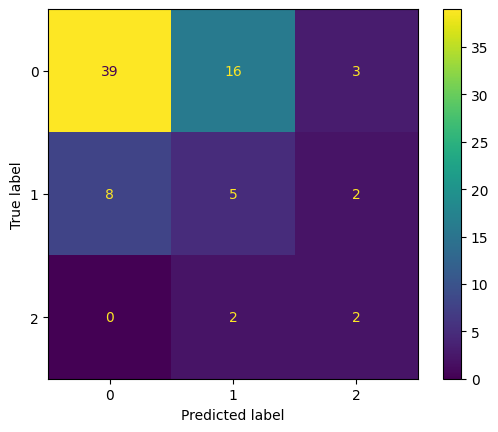

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, auc, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import roc_auc_score, accuracy_score
torch.manual_seed(1234)

loss_fn = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10,
                              min_lr=0.00001)

best_loss = np.inf

def train(epoch):
    model.train()
    total_loss = 0
    accuracy = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = loss_fn(out, data.y.to(torch.long))
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    total_error = 0
    total_true = []
    total_score = []
    total_pred = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        total_error += loss_fn(out, data.y.to(torch.long)).item() * data.num_graphs
        total_true.extend(data.y.tolist())
        total_score.extend(out.softmax(dim=1).tolist())
        total_pred.extend(out.softmax(dim=1).argmax(dim=1).tolist())

    roc = roc_auc_score(total_true, total_score,average="macro", multi_class='ovo')
    cm = confusion_matrix(total_true, total_pred)
    return total_error / len(loader.dataset), roc, cm


for epoch in range(1, 301):
    loss = train(epoch)
    val_loss, roc, cm = test(validation_loader)
    test_loss, test_roc, test_cm = test(test_loader)
    scheduler.step(val_loss)
    if epoch >= 5:
        if val_loss < best_loss:
            best_loss = val_loss
            best_roc = test_roc
            best_cm = test_cm
            epoch_count = 0
        else:
            epoch_count += 1
        if epoch_count >= 20:
            break
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_loss:.4f}, Test: {test_loss:.4f} ROC: {roc:.4f}')
print("ROC",best_roc)
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm)
disp.plot()